<a href="https://colab.research.google.com/github/ayyucedemirbas/Medical_Img_Seg/blob/main/grounded_DINO_SAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import cv2
import os
import sys

In [2]:
HOME = os.getcwd()

In [3]:
HOME

'/content'

In [4]:
%cd {HOME}

/content


In [5]:
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd {HOME}/GroundingDINO
!git checkout -q 57535c5a79791cb76e36fdb64975271354f10251
!pip install -q -e .

Cloning into 'GroundingDINO'...
remote: Enumerating objects: 463, done.
remote: Counting objects: 100% (240/240), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 463 (delta 175), reused 135 (delta 135), pack-reused 223 (from 1)
Receiving objects: 100% (463/463), 12.87 MiB | 9.62 MiB/s, done.
Resolving deltas: 100% (241/241), done.
/content/GroundingDINO
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 70.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 19.8 MB/s eta 0:00:00


In [6]:
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!mkdir -p {HOME}/weights
%cd {HOME}/weights
#downloading pretrained Grounding dino weights
!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth
!mkdir -p {HOME}/weights
%cd {HOME}/weights

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-un3wdbxs
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-un3wdbxs
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=6f41df67c429e3d05146dc91d155087a6cb0f427b656e8ff0bb19f6a8ba40180
  Stored in directory: /tmp/pip-ephem-wheel-cache-4jxy6x5r/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment_anything
/content/weights
/content/weights


In [7]:
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
%cd {HOME}
#checking if all the necessary files exist
GROUNDING_DINO_CHECKPOINT_PATH = os.path.join(HOME, "weights", "groundingdino_swint_ogc.pth")
print(GROUNDING_DINO_CHECKPOINT_PATH, "; exist:", os.path.isfile(GROUNDING_DINO_CHECKPOINT_PATH))
GROUNDING_DINO_CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(GROUNDING_DINO_CONFIG_PATH, "; exist:", os.path.isfile(GROUNDING_DINO_CONFIG_PATH))
SAM_CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(SAM_CHECKPOINT_PATH, "; exist:", os.path.isfile(SAM_CHECKPOINT_PATH))

/content
/content/weights/groundingdino_swint_ogc.pth ; exist: True
/content/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True
/content/weights/sam_vit_h_4b8939.pth ; exist: True


In [8]:
!pip uninstall -y supervision
!pip install -q supervision==0.6.0

import supervision as sv
print(sv.__version__)

Found existing installation: supervision 0.4.0
Uninstalling supervision-0.4.0:
  Successfully uninstalled supervision-0.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
groundingdino 0.1.0 requires supervision==0.4.0, but you have supervision 0.6.0 which is incompatible.
0.6.0


In [9]:
%cd {HOME}/GroundingDINO

from groundingdino.util.inference import Model

grounding_dino_model = Model(model_config_path=GROUNDING_DINO_CONFIG_PATH, model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH)

SAM_ENCODER_VERSION = "vit_h"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from segment_anything import sam_model_registry, SamPredictor

sam = sam_model_registry[SAM_ENCODER_VERSION](checkpoint=SAM_CHECKPOINT_PATH).to(device=DEVICE)
sam_predictor = SamPredictor(sam)

/content/GroundingDINO


/usr/local/lib/python3.10/dist-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/content/GroundingDINO/groundingdino/util/inference.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_checkpoint_path, map_location="cpu")
/

In [10]:
%cd {HOME}
!mkdir {HOME}/data
%cd {HOME}/data

/content
/content/data


In [17]:
SOURCE_IMAGE_PATH = f"{HOME}/abdomen.jpg"
CLASSES = ['liver', 'spleen', 'stomach', 'aorta']
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25
def add_all_suffix(class_names):
    result = []
    for class_name in class_names:
        result.append("all " + class_name + "s")
    return result
class_names = add_all_suffix(CLASSES)
#class_names =['all watchs', 'all sunglassess', 'all phones', 'all headphones']

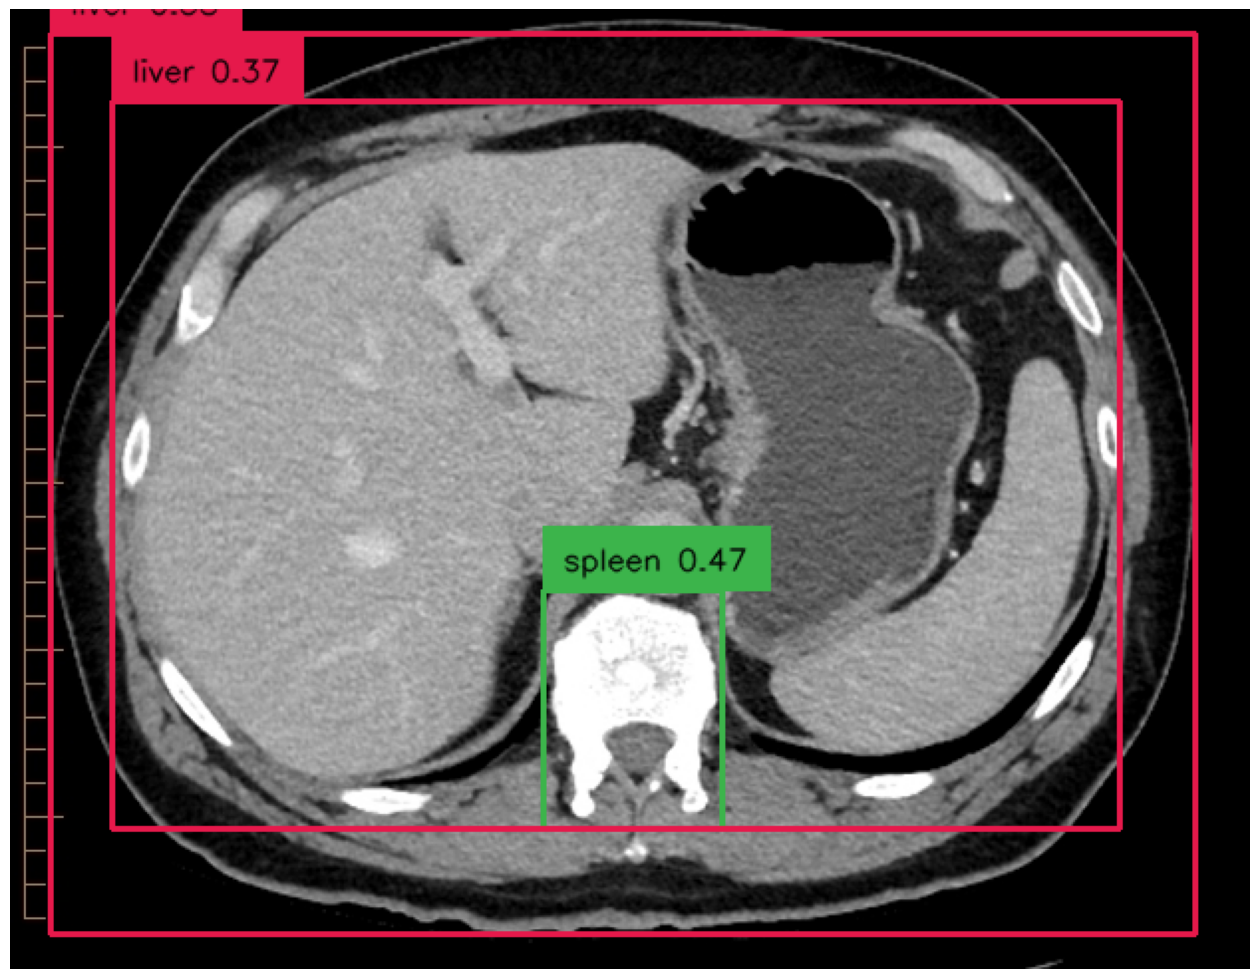

In [18]:
# load image
image = cv2.imread(SOURCE_IMAGE_PATH)

# detect objects
detections = grounding_dino_model.predict_with_classes(
    image=image,
    classes=class_names,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

# annotate image with detections
box_annotator = sv.BoxAnnotator()
labels = [
    f"{CLASSES[class_id]} {confidence:0.2f}"
    for _, _, confidence, class_id, _
    in detections]
annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))

In [19]:
import numpy as np
from segment_anything import SamPredictor


def segment(sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
    sam_predictor.set_image(image)
    result_masks = []
    for box in xyxy:
        masks, scores, logits = sam_predictor.predict(
            box=box,
            multimask_output=True
        )
        index = np.argmax(scores)
        result_masks.append(masks[index])
    return np.array(result_masks)

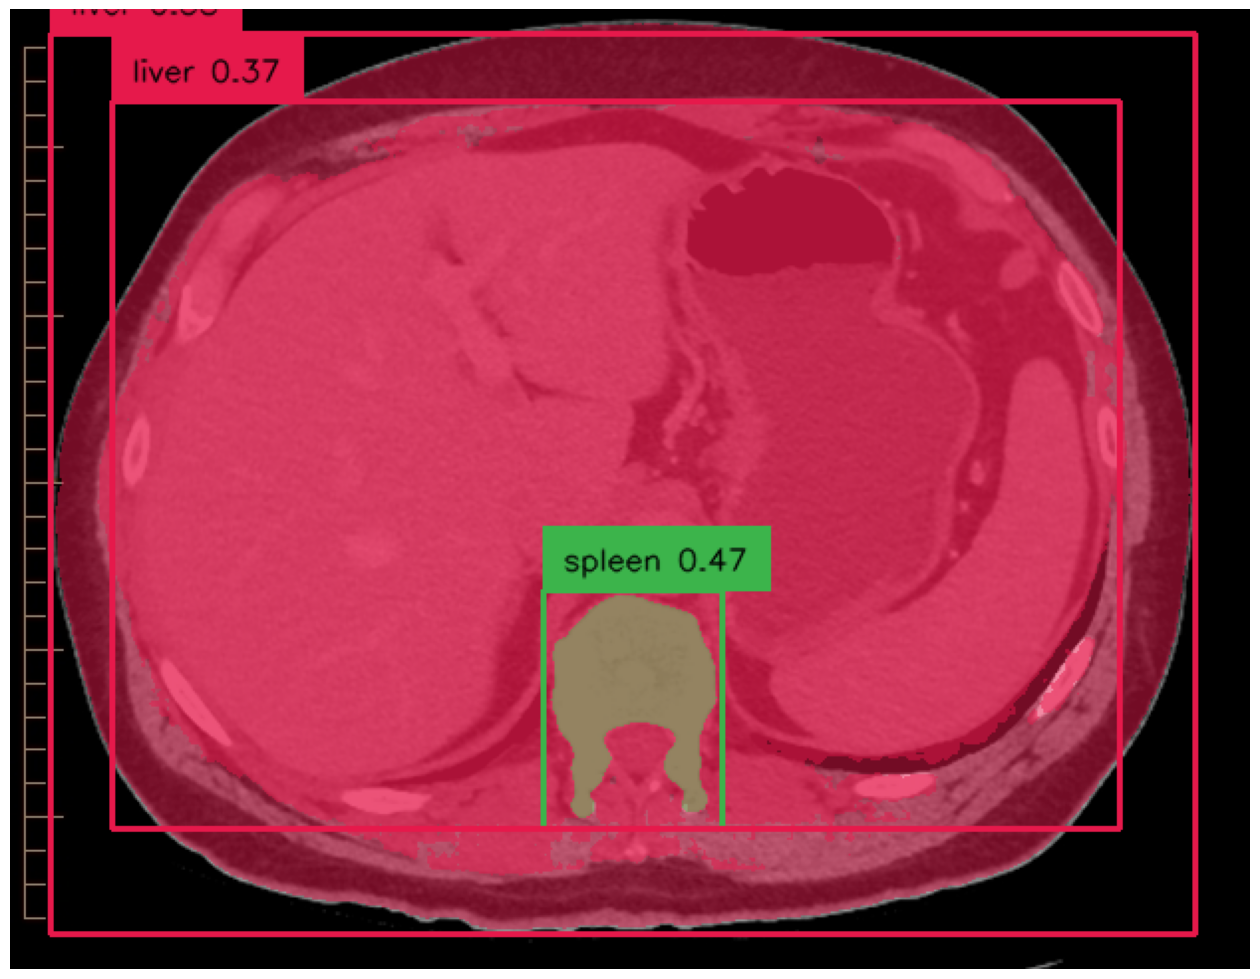

In [20]:
# convert detections to masks
detections.mask = segment(
sam_predictor=sam_predictor,
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
xyxy=detections.xyxy
)
# annotate image with detections
box_annotator = sv.BoxAnnotator()
mask_annotator = sv.MaskAnnotator()
labels = [
f"{CLASSES[class_id]} {confidence:0.2f}"
for _, _, confidence, class_id, _
in detections]#if you dont update SV you will face problems here .
annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)
%matplotlib inline
sv.plot_image(annotated_image, (16, 16))

In [31]:
SOURCE_IMAGE_PATH = f"{HOME}/organs.jpg"
CLASSES = ['liver', 'stomach', 'heart', 'lung', 'colon', 'pancreas', 'gallbladder']
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25
def add_all_suffix(class_names):
    result = []
    for class_name in class_names:
        result.append("all " + class_name + "s")
    return result
class_names = add_all_suffix(CLASSES)
#class_names =['all watchs', 'all sunglassess', 'all phones', 'all headphones']

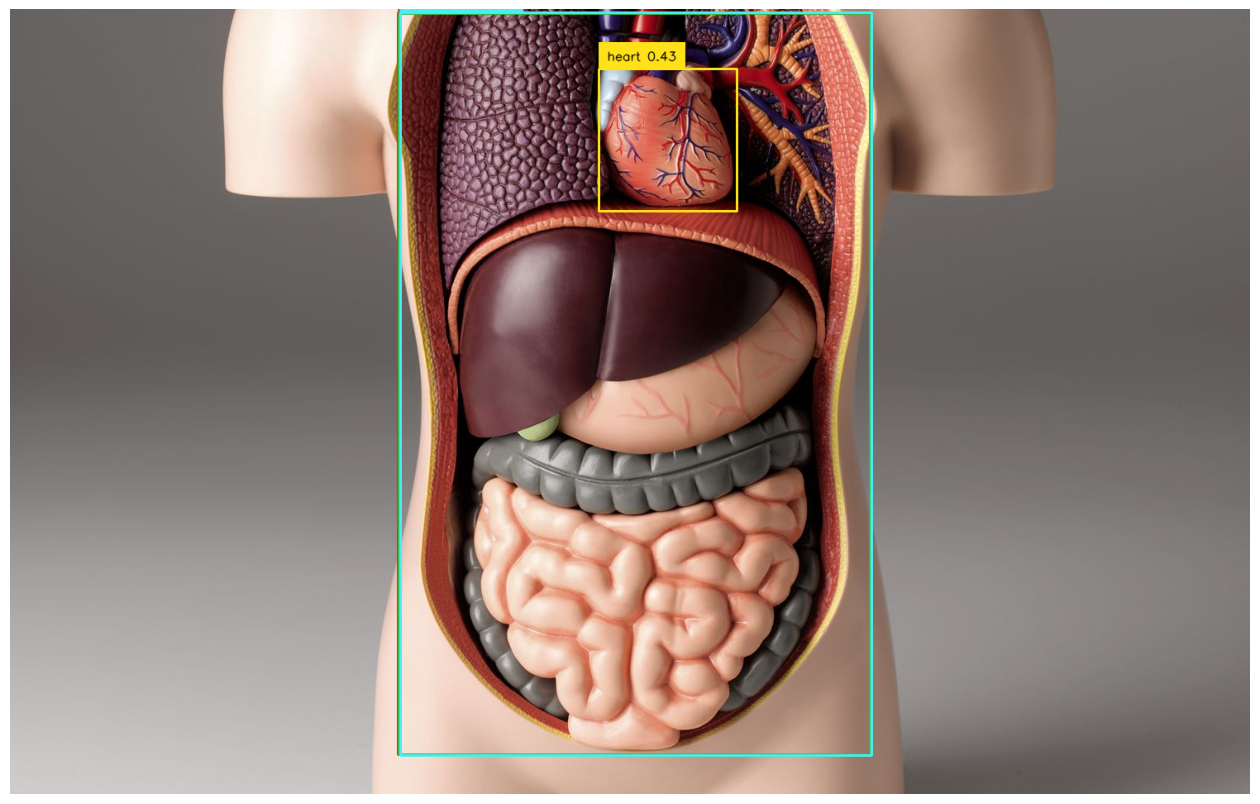

In [32]:
# load image
image = cv2.imread(SOURCE_IMAGE_PATH)

# detect objects
detections = grounding_dino_model.predict_with_classes(
    image=image,
    classes=class_names,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

# annotate image with detections
box_annotator = sv.BoxAnnotator()
labels = [
    f"{CLASSES[class_id]} {confidence:0.2f}"
    for _, _, confidence, class_id, _
    in detections]
annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))

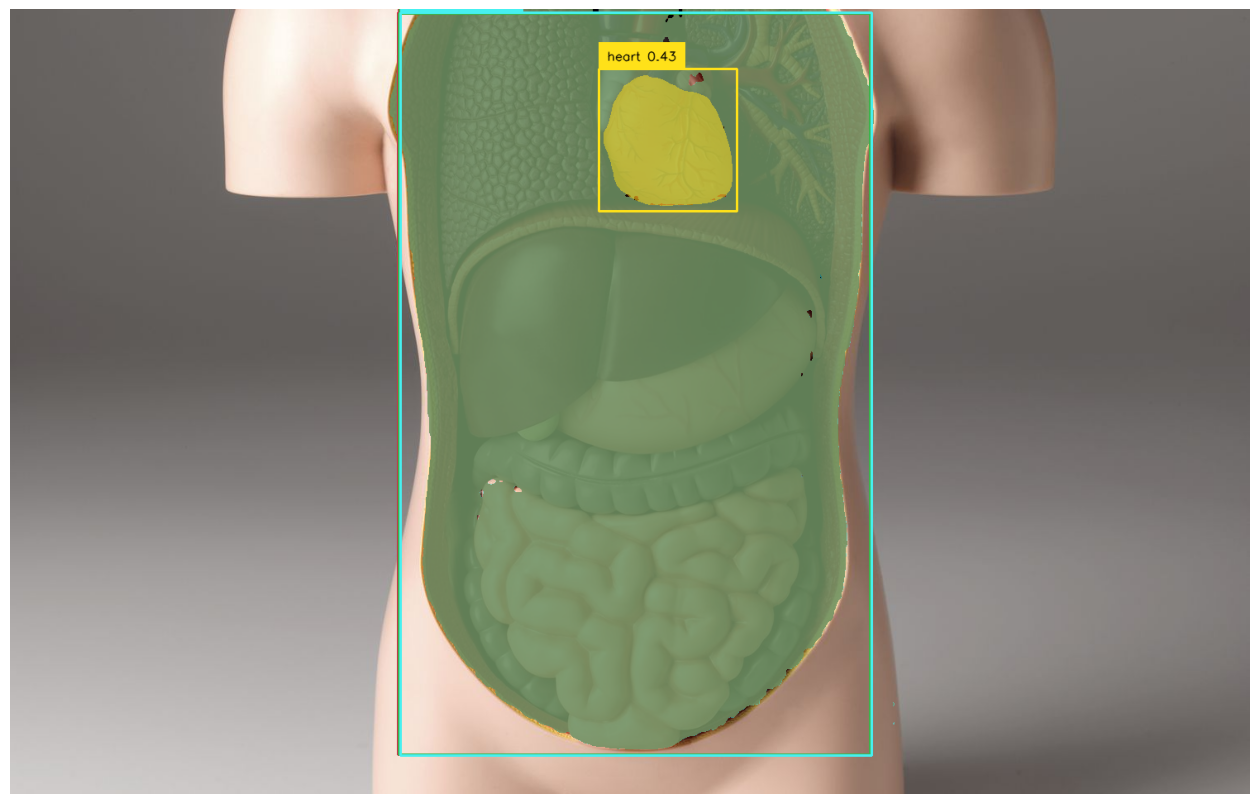

In [34]:
# convert detections to masks
detections.mask = segment(
sam_predictor=sam_predictor,
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
xyxy=detections.xyxy
)
# annotate image with detections
box_annotator = sv.BoxAnnotator()
mask_annotator = sv.MaskAnnotator()
labels = [
f"{CLASSES[class_id]} {confidence:0.2f}"
for _, _, confidence, class_id, _
in detections]#if you dont update SV you will face problems here .
annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)
%matplotlib inline
sv.plot_image(annotated_image, (16, 16))